Baseline을 기반으로 코드를 작성했습니다. baseline과 다른 곳에 주석을 달겠습니다.

In [1]:
#-*- coding: utf-8 -*-

In [2]:
%reload_ext watermark

In [3]:
%watermark -v -p dateutil,numpy,matplotlib,pandas,torch,tqdm,TaPR_pkg,cv2

CPython 3.6.13
IPython 7.16.1

dateutil 2.8.2
numpy 1.18.5
matplotlib 3.3.4
pandas 1.1.5
torch 1.9.1
tqdm 4.62.3
TaPR_pkg unknown
cv2 4.5.3


In [4]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

import os
import random

import torch.nn as nn
from scipy import signal

In [5]:
# random seed를 고정하기 위해서 사용했습니다.
def seed_everything(seed = 777):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [6]:
TRAIN_DATASET = sorted([x for x in Path("./data/train").glob("*.csv")])
TRAIN_DATASET

[PosixPath('data/train/train1.csv'),
 PosixPath('data/train/train2.csv'),
 PosixPath('data/train/train3.csv'),
 PosixPath('data/train/train4.csv'),
 PosixPath('data/train/train5.csv'),
 PosixPath('data/train/train6.csv')]

In [7]:
TEST_DATASET = sorted([x for x in Path("./data/test").glob("*.csv")])
TEST_DATASET

[PosixPath('data/test/test1.csv'),
 PosixPath('data/test/test2.csv'),
 PosixPath('data/test/test3.csv')]

In [8]:
VALIDATION_DATASET = sorted([x for x in Path("./data/validation").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('data/validation/validation.csv')]

In [9]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [10]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,2021-08-09 08:59:56,-2.0065,0,12.26196,0.00051,100.28228,0.5977,12.53358,70,1,...,1.17355,35.05434,10.00000,3178.48877,370.02679,1,986.05908,12.0,50,136
259196,2021-08-09 08:59:57,-2.2101,0,12.26196,-0.00029,100.28228,0.5509,12.53358,70,1,...,1.16898,35.03488,10.00000,3175.36084,370.40656,1,986.05908,12.0,50,89
259197,2021-08-09 08:59:58,-2.3325,0,12.26196,0.00152,100.28228,0.5425,12.53358,70,1,...,1.16974,35.02840,10.00000,3175.73608,368.12787,1,986.05908,12.0,50,90
259198,2021-08-09 08:59:59,-2.3049,0,12.26196,0.00058,100.26703,0.6266,12.53358,70,1,...,1.16974,35.02420,10.00000,3176.61182,368.01941,1,986.05908,12.0,50,74


In [11]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

In [12]:
# 사용할 index를 지정합니다.
LEAV_IDX = [11,15,22,23,26,27,29,30,31,39,42,52,55,58,61,64,67,69,72,74,75,76,80,82]

In [13]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [14]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [15]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.433107,0.0,0.056338,0.501686,0.116706,0.447955,0.816071,0.0,0.0,0.0,...,0.240561,0.194185,0.708818,0.183693,0.169066,0.0,0.538147,0.0,0.0,0.276078
1,0.395098,0.0,0.056338,0.517560,0.121738,0.397053,0.816071,0.0,0.0,0.0,...,0.240561,0.194535,0.708818,0.165517,0.168332,0.0,0.538147,0.0,0.0,0.275176
2,0.333267,0.0,0.056338,0.504886,0.139408,0.405431,0.816071,0.0,0.0,0.0,...,0.238319,0.195226,0.708818,0.141083,0.180570,0.0,0.538147,0.0,0.0,0.274889
3,0.446345,0.0,0.056338,0.522383,0.154058,0.436703,0.816071,0.0,0.0,0.0,...,0.236754,0.196440,0.708818,0.125447,0.187292,0.0,0.538147,0.0,0.0,0.277264
4,0.328324,0.0,0.056338,0.517845,0.157091,0.439827,0.816071,0.0,0.0,0.0,...,0.237495,0.196492,0.708818,0.117700,0.187419,0.0,0.538147,0.0,0.0,0.275990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,0.485034,0.0,0.056340,0.515751,0.994085,0.520004,0.640361,0.0,0.0,0.0,...,0.403941,0.696846,1.000000,0.996289,0.517805,0.0,0.414192,0.0,0.0,0.018717
259196,0.447224,0.0,0.056338,0.509379,0.994085,0.510481,0.640361,0.0,0.0,0.0,...,0.401381,0.695028,1.000000,0.995484,0.518674,0.0,0.414192,0.0,0.0,0.015676
259197,0.423251,0.0,0.056338,0.528358,0.994085,0.508101,0.640361,0.0,0.0,0.0,...,0.401571,0.694256,1.000000,0.995510,0.511131,0.0,0.414192,0.0,0.0,0.015440
259198,0.425407,0.0,0.056338,0.520068,0.993949,0.522157,0.640361,0.0,0.0,0.0,...,0.401590,0.693797,1.000000,0.995761,0.510014,0.0,0.414192,0.0,0.0,0.014318


In [16]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [17]:
boundary_check(TRAIN_DF)

(False, False, False)

window size는 이전 대회에서 많이 사용한 39를 사용했습니다.

In [18]:
WINDOW_GIVEN = 39
WINDOW_SIZE = 40


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [19]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=1)
HAI_DATASET_TRAIN[0]

  0%|          | 0/1004363 [00:00<?, ?it/s]

# of valid windows: 1004168


{'ts': '2021-07-11 10:00:39',
 'given': tensor([[0.4331, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2761],
         [0.3951, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2752],
         [0.3333, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2749],
         ...,
         [0.3150, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2600],
         [0.4407, 0.0000, 0.0577,  ..., 0.0000, 0.0000, 0.2583],
         [0.3572, 0.0000, 0.0551,  ..., 0.0000, 0.0000, 0.2563]]),
 'answer': tensor([3.5958e-01, 0.0000e+00, 5.6212e-02, 5.3530e-01, 1.4813e-01, 4.2156e-01,
         8.1607e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.1665e-01, 5.7758e-01,
         4.2336e-01, 4.4602e-01, 2.5236e-01, 2.2022e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 3.0503e-01, 4.4349e-01, 0.0000e+00, 2.5463e-01, 5.6910e-01,
         5.9176e-01, 0.0000e+00, 2.5426e-01, 2.4381e-01, 0.0000e+00, 9.7483e-01,
         5.5928e-01, 2.9944e-01, 3.7788e-01, 0.0000e+00, 9.0094e-01, 0.0000e+00,
         2.0972e-01, 0.0000e+00, 0.0000e+00, 2.5755e-02, 2.

## 모델
1. stacked gru : baseline과 같은 stacked gru를 사용했지만 성능이 좋지 않아서 사용하지 않았습니다.
2. transformer의 encoder + skip connection : stacked gru보다 성능이 좋지 못해서 사용하지 않았습니다.
3. stacked lstm + attention + mixup: baseline코드에 feature별 가중치를 attention을 통해서 부여하였습니다. 성능이 앞선 두 모델에 비해 좋아서 사용하게 되었습니다.

In [20]:
N_HIDDENS = 200
N_LAYERS = 3
BATCH_SIZE = 2024
epoch = 130

class StackedLSTM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = torch.nn.LSTM(
            input_size=24,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0.1
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2,24)
        self.relu = torch.nn.LeakyReLU(0.1)
        
        # mix up을 적용하기 위해서 learnable parameter인 w를 설정합니다.
        w = torch.nn.Parameter(torch.FloatTensor([-0.01]), requires_grad=True)
        w = torch.nn.Parameter(w, requires_grad=True)
        self.w = w
        
        self.sigmoid = torch.nn.Sigmoid()
        
        # feature attention을 위한 dense layer를 설정합니다.
        self.dense1 = torch.nn.Linear(24, 12)
        self.dense2 = torch.nn.Linear(12, 24)

    def forward(self, x):
        x = x[:,:,LEAV_IDX] # batch, window_size, params

        pool = torch.nn.AdaptiveAvgPool1d(1)
        
        attention_x = x
        attention_x = attention_x.transpose(1,2) # batch, params, window_size
        
        attention = pool(attention_x) # batch, params, 1
        
        connection = attention # 이전 정보를 저장하고 있습니다.
        connection = connection.reshape(-1,24) # batch, params
        
        # feature attention을 적용합니다.
        attention = self.relu(torch.squeeze(attention))
        attention = self.relu(self.dense1(attention))
        attention = self.sigmoid(self.dense2(attention)) # sigmoid를 통해서 (batch, params)의 크기로 확률값이 나타나 있는 attention을 생성합니다.

        x = x.transpose(0, 1)  # (batch, window_size, params) -> (window_size, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(self.relu(outs[-1])) # 이전 대회 코드를 보고 leaky relu를 추가했습니다.

        mix_factor = self.sigmoid(self.w) # w의 값을 비율로 만들어 주기 위해서 sigmoid를 적용합니다.

        return mix_factor * connection * attention + out * (1 - mix_factor) # 이전 정보와 stacked lstm을 통해 skip connection을 진행합니다. 이때, 비율은 mix_factor에 의해 결정됩니다.

In [21]:
torch.__version__

'1.9.1+cu102'

In [22]:
MODEL = StackedLSTM()
MODEL.cuda()

StackedLSTM(
  (rnn): LSTM(24, 200, num_layers=3, dropout=0.1, bidirectional=True)
  (fc): Linear(in_features=400, out_features=24, bias=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (sigmoid): Sigmoid()
  (dense1): Linear(in_features=24, out_features=12, bias=True)
  (dense2): Linear(in_features=12, out_features=24, bias=True)
)

In [23]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            loss = loss_fn(answer[:,LEAV_IDX], guess) # answer도 86개의 feature가 있기 때문에 LEAV_IDX만 사용하기 위해 작성
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

In [24]:
MODEL.train()
BEST_MODEL, LOSS_HISTORY =train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, epoch)

training:   0%|          | 0/130 [00:00<?, ?it/s]

In [25]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]

(0.005923920277382422, 129)

In [26]:
with open("./data/model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

In [27]:
with open("./data/model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

<All keys matched successfully>

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


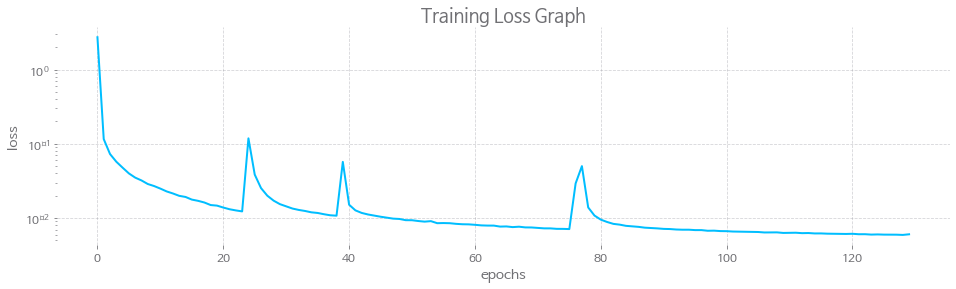

In [28]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

In [29]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,...,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,...,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,...,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,...,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,...,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,...,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
86396,2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,...,31.79738,0.716042,1179.76929,348.03607,1,1018.394040,12.0,50,7,0
86397,2021-07-10 23:59:58,-2.3564,0,12.26196,-0.00101,15.53497,0.2907,12.669310,70,1,...,31.78784,0.716042,1152.66187,348.81366,1,1018.394040,12.0,50,7,0
86398,2021-07-10 23:59:59,-2.1541,0,12.26196,-0.00166,15.53497,0.3280,12.669310,70,1,...,31.77029,0.716042,1130.65723,349.13916,1,1018.394040,12.0,50,7,0


In [30]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

In [31]:
boundary_check(VALIDATION_DF)

(True, True, False)

In [32]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]

  0%|          | 0/86361 [00:00<?, ?it/s]

# of valid windows: 86361


{'attack': 0.0,
 'ts': '2021-07-10 00:00:40',
 'given': tensor([[ 0.4743,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0208],
         [ 0.4517,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0204],
         [ 0.3819,  0.0000, -0.0421,  ...,  0.0000,  0.0000,  0.0200],
         ...,
         [ 0.4374,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.3905],
         [ 0.3432,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.3916],
         [ 0.4618,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.3994]]),
 'answer': tensor([ 0.3281,  0.0000, -0.0407,  0.4876,  0.1540,  0.4123,  1.1192,  0.0000,
          0.0000,  0.0000,  0.3196,  0.3783,  0.5393,  0.4657,  0.3918,  0.1930,
          0.0000,  0.0000,  0.0000,  0.8439,  0.4704,  0.0000,  0.1612,  0.3346,
          0.2411,  0.0000,  0.1595,  0.1252,  0.0000,  0.9942,  0.5999,  0.2359,
          0.2470,  0.0000,  0.9909,  0.0000,  0.3079,  0.0000,  0.0000,  0.0399,
          0.1511,  0.5177,  0.3998,  0.3364,  0.9982,  1.0000,  0.3914,  1.0000,
       

In [33]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer[:,LEAV_IDX] - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [34]:
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

In [35]:
CHECK_DIST.shape

(86361, 24)

In [36]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [37]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

In [38]:
# 이전 대회의 데이터 후처리를 참고했습니다. moving average보다 lowpass filter를 적용하는 것이 성능이 좋아서 이를 선택했습니다.
b, a = signal.butter(1, 0.02, btype='lowpass')

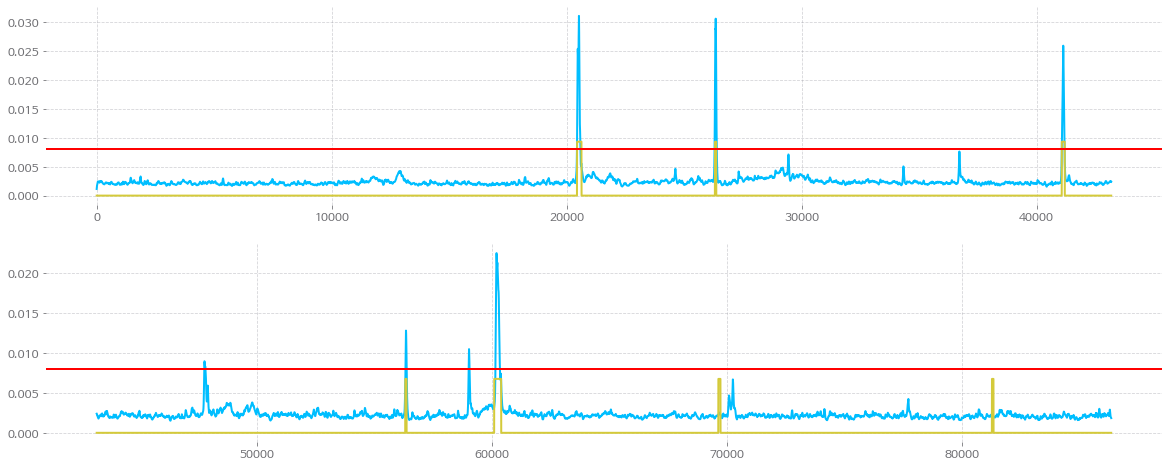

In [39]:
THRESHOLD = 0.008

check_graph(signal.filtfilt(b,a,ANOMALY_SCORE), CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

In [40]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [41]:
LABELS = put_labels(signal.filtfilt(b,a,ANOMALY_SCORE), THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (86361,))

In [42]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

In [43]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [44]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 14.9 s, sys: 25.5 ms, total: 14.9 s
Wall time: 14.9 s


(86400,)

In [45]:
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.633 (TaP: 0.669, TaR: 0.600)
# of detected anomalies: 5
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fe9550b8f60>, <TaPR_pkg.DataManage.Range.Range object at 0x7fe9550b8fd0>, <TaPR_pkg.DataManage.Range.Range object at 0x7fe9550b5080>, <TaPR_pkg.DataManage.Range.Range object at 0x7fe9550b8ef0>, <TaPR_pkg.DataManage.Range.Range object at 0x7fe9550b50b8>]


In [46]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-13 16:00:01,-2.1424,0,12.37640,-0.00275,8.02002,0.1524,12.58874,70,1,...,1.13464,29.09910,2.85153,227.61664,333.51416,1,981.36951,12.0,50,2100
1,2021-07-13 16:00:02,-2.0449,0,12.37640,-0.00087,8.02002,0.1281,12.58874,70,1,...,1.13312,29.14869,2.85153,231.58908,340.18738,1,981.36951,12.0,50,2165
2,2021-07-13 16:00:03,-2.1287,0,12.37640,-0.00260,8.02002,0.0148,12.58874,70,1,...,1.13388,29.18836,2.85153,229.60286,347.14990,1,981.36951,12.0,50,2209
3,2021-07-13 16:00:04,-2.1287,0,12.37640,-0.00282,8.02002,0.0148,12.58874,70,1,...,1.13541,29.24558,2.85153,229.60286,355.90277,1,981.36951,12.0,50,2233
4,2021-07-13 16:00:05,-2.5969,0,12.37640,0.00058,8.02002,-0.2225,12.58874,70,1,...,1.13541,29.24558,2.85153,222.65125,358.23566,1,981.36951,12.0,50,2290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,2021-07-16 23:59:56,-1.8328,0,12.07123,0.00036,15.03143,0.8050,12.58870,70,1,...,0.92941,29.45263,2.40398,1056.03259,373.20966,1,1015.06964,12.0,50,22
129596,2021-07-16 23:59:57,-1.8328,0,12.07123,-0.00470,13.74206,0.8050,12.58870,70,1,...,0.92255,29.45758,2.40398,1026.05530,376.66376,1,1015.06964,12.0,50,22
129597,2021-07-16 23:59:58,-1.5833,0,12.07123,-0.00130,13.64288,0.9984,12.58870,70,1,...,0.92255,29.45034,2.40398,981.37659,377.76691,1,1015.06964,12.0,50,22
129598,2021-07-16 23:59:59,-1.4022,0,12.07123,0.00087,13.62762,1.0595,12.58870,70,1,...,0.92255,29.43088,2.40398,919.62439,378.99664,1,1015.06964,12.0,50,22


In [47]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.455432,0.0,0.079812,0.479046,0.077046,0.434169,0.711769,0.0,0.0,0.0,...,0.378726,0.095024,0.285153,0.068104,0.381526,0.0,0.393961,0.0,0.0,0.168791
1,0.471678,0.0,0.079812,0.499628,0.077046,0.429998,0.711769,0.0,0.0,0.0,...,0.377826,0.099579,0.285153,0.069240,0.404094,0.0,0.393961,0.0,0.0,0.173300
2,0.459304,0.0,0.079812,0.482713,0.077046,0.410346,0.711769,0.0,0.0,0.0,...,0.378191,0.103601,0.285153,0.068779,0.429462,0.0,0.393961,0.0,0.0,0.176731
3,0.458079,0.0,0.079812,0.478654,0.077046,0.408400,0.711769,0.0,0.0,0.0,...,0.379124,0.109204,0.285153,0.068734,0.461282,0.0,0.393961,0.0,0.0,0.178719
4,0.380719,0.0,0.079812,0.515098,0.077046,0.367874,0.711769,0.0,0.0,0.0,...,0.379218,0.109763,0.285153,0.066761,0.472272,0.0,0.393961,0.0,0.0,0.182832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,0.511523,0.0,0.017216,0.516825,0.147339,0.557125,0.711717,0.0,0.0,0.0,...,0.245764,0.130889,0.240398,0.327644,0.529605,0.0,0.539339,0.0,0.0,0.010225
129596,0.512114,0.0,0.017216,0.461690,0.135262,0.557380,0.711717,0.0,0.0,0.0,...,0.241081,0.131212,0.240398,0.320111,0.540804,0.0,0.539339,0.0,0.0,0.010225
129597,0.553332,0.0,0.017216,0.493026,0.133167,0.590276,0.711717,0.0,0.0,0.0,...,0.240613,0.130586,0.240398,0.306708,0.545617,0.0,0.539339,0.0,0.0,0.010225
129598,0.587329,0.0,0.017216,0.519678,0.132821,0.603950,0.711717,0.0,0.0,0.0,...,0.240566,0.128753,0.240398,0.287885,0.550216,0.0,0.539339,0.0,0.0,0.010225


In [48]:
boundary_check(TEST_DF)

(True, True, False)

In [49]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)

  0%|          | 0/274761 [00:00<?, ?it/s]

# of valid windows: 274683


In [50]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

CPU times: user 7.64 s, sys: 5.13 s, total: 12.8 s
Wall time: 12.8 s


In [51]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

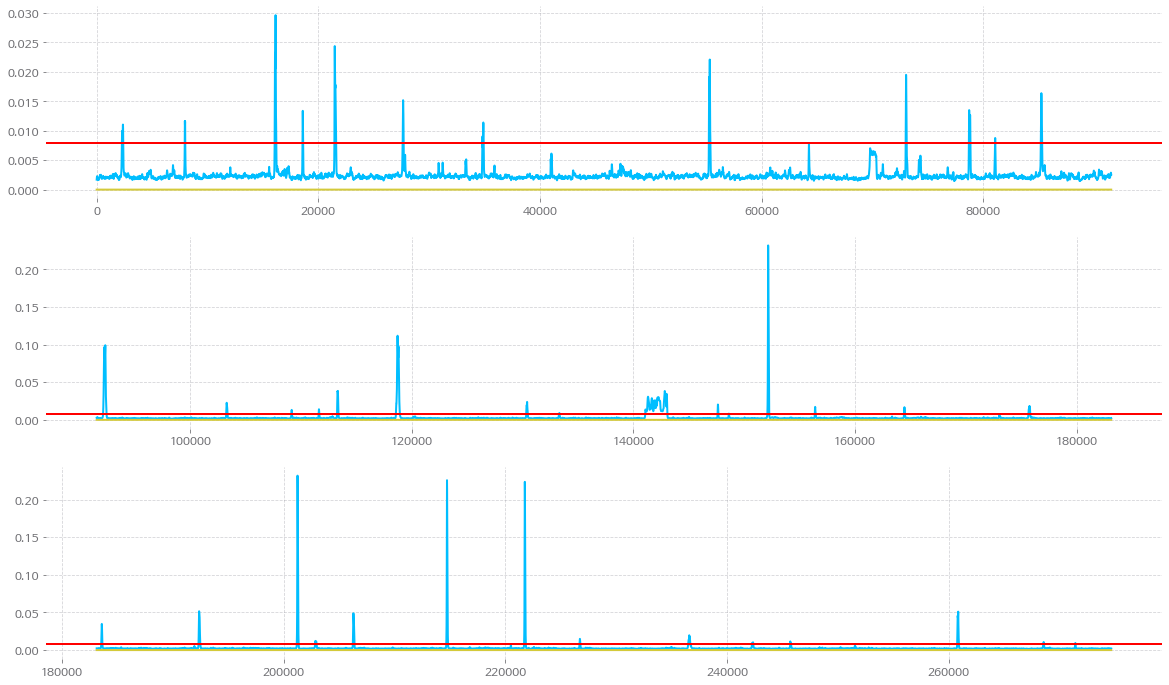

In [52]:
check_graph(signal.filtfilt(b,a,ANOMALY_SCORE), CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [53]:
LABELS = put_labels(signal.filtfilt(b,a,ANOMALY_SCORE), THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (274683,))

In [54]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0.0
2021-07-13 16:00:02,2021-07-13 16:00:02,0.0
2021-07-13 16:00:03,2021-07-13 16:00:03,0.0
2021-07-13 16:00:04,2021-07-13 16:00:04,0.0
2021-07-13 16:00:05,2021-07-13 16:00:05,0.0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,0.0
2021-07-16 23:59:57,2021-07-16 23:59:57,0.0
2021-07-16 23:59:58,2021-07-16 23:59:58,0.0


In [55]:
submission.to_csv('./data/submission_final.csv', index=False)